<a href="https://colab.research.google.com/github/simulate111/Data-Science_2024/blob/main/Tanjim_Pranto_Mini_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini Project 1 : What should I cook tonight?**
TANJIM PRANTO
ÅAU student ID- 2302479,
tanjim.pranto@abo.fi

In [1]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,159 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,318 kB]
Fetched 3,734 kB in 4s (1,024 kB/s)

In [2]:
!pip install chromedriver-autoinstaller
!pip install selenium-stealth

In [3]:
from selenium_stealth import stealth
from selenium.common.exceptions import NoSuchElementException

import sys
sys.path.insert(0, '/usr/lib/chromium-browse/chromedriver')
from selenium import webdriver
import chromedriver_autoinstaller

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.service import Service

import pandas as pd
import time
import re
import csv
import os

# Step 1  Webscraping
Scrape the data of the first 50 pages of the website https://www.skinnytaste.com

In [4]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.set_capability("browserVersion", "129.0.6668.59")
chrome_options.add_argument("--window-size=2560,1440")
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chromedriver_autoinstaller.install()
options = webdriver.ChromeOptions()


driver = webdriver.Chrome(options=chrome_options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )


# List to store scraped data
recipes_data = []

def scrape_one_page(page_number):
    url = f"https://www.skinnytaste.com/page/{page_number}/"
    driver.get(url)
    print(f"Scraping page {page_number}")

    try:
        # Using WebDriverWait to wait for the presence of recipes on the page
        recipes = WebDriverWait(driver, 30).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.post-grid-post"))
        )

        for index, recipe in enumerate(recipes):
            try:
                # Scroll the recipe element into view to trigger lazy loading and other effects
                driver.execute_script("arguments[0].scrollIntoView();", recipe)
                time.sleep(1)  # Small pause to allow the lazy loading to complete

                # Attempt to find the title using the primary selector
                try:
                    title_element = recipe.find_element(By.CSS_SELECTOR, "div.post-grid-post-title h2.entry-title a")
                    print(f"Primary title element found for Recipe {index+1}")
                except:
                    # Fallback to alternative selector if primary fails
                    try:
                        title_element = recipe.find_element(By.CSS_SELECTOR, "div.post-grid-post-title-container h3.entry-title a")
                        print(f"Alternative title element found for Recipe {index+1}")
                    except:
                        # Another fallback if needed (if structure is different)
                        try:
                            title_element = recipe.find_element(By.CSS_SELECTOR, "div.post-grid-post-title a")
                            print(f"Fallback title element found for Recipe {index+1}")
                        except:
                            print(f"Failed to find title for Recipe {index+1}")
                            continue

                recipe_name = title_element.text
                recipe_link = title_element.get_attribute('href')

                # Extract categories (if any)
                categories = []
                category_elements = recipe.find_elements(By.CSS_SELECTOR, "ul.cat-icons.post-icons li a")
                for cat in category_elements:
                    categories.append(cat.text)

                # Visit the individual recipe link to extract detailed information
                driver.execute_script("window.open('');")  # Open a new tab
                driver.switch_to.window(driver.window_handles[1])  # Switch to the new tab
                driver.get(recipe_link)
                time.sleep(2)  # Wait for the page to load

                # Scrape detailed information from the individual recipe page
                detailed_info = scrape_individual_recipe_page(driver, recipe_link)

                # Close the tab and switch back to the main tab
                driver.close()
                driver.switch_to.window(driver.window_handles[0])

                # Skip adding the recipe if detailed info is None (e.g., no image was found)
                if detailed_info is None:
                    print(f"Skipped: {recipe_name} (No Image)")
                    continue

                # Append the extracted data with detailed info
                recipes_data.append({
                    "Name": recipe_name,
                    "Link": recipe_link,
                    "Image URL": detailed_info.get("Image URL"),
                    "Recipe Key": ", ".join(categories),
                    "All Recipe Key Full Form": detailed_info.get("Recipe Key"),
                    "WW Points": detailed_info.get("WW Points"),
                    "Nutrition": detailed_info.get("Nutrition"),
                    "Cooking Time": detailed_info.get("Cooking Time"),
                    "Course": detailed_info.get("Course"),
                    "Cuisine": detailed_info.get("Cuisine"),
                    "Summary": detailed_info.get("Summary"),
                    "Ingredients": detailed_info.get("Ingredients"),
                    "Instructions": detailed_info.get("Instructions"),
                    "Recipe Categories/Tags": detailed_info.get("Page Categories")
                })
                print(f"Scraped: {recipe_name}")
            except Exception as e:
                print(f"Failed to scrape a recipe on page {page_number}: {e}")

    except Exception as e:
        print(f"Failed to load recipes on page {page_number}: {e}")

def scrape_individual_recipe_page(driver, url):
    # Function to scrape details from an individual recipe page
    print(f"Scraping detailed info for: {url}")
    details = {}
    try:
# Recipe Image URL
        try:
            # Locating the image inside divs
            image_element = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-image img")
            image_url = image_element.get_attribute("src")

            # If src is empty or contains placeholder SVG, check for lazy-loaded attributes
            if not image_url or 'data:image/svg+xml' in image_url:
                image_url = image_element.get_attribute("data-lazy-src") or image_element.get_attribute("data-src")

            # Printing the extracted image URL
            if image_url:
                print(f"Image URL extracted: {image_url}")
            else:
                print("Image URL is empty.")
        except NoSuchElementException:
            image_url = None
            print("It is a meal plan/catalogue or a lifestyle blog. And this is not a single recipe data page")

        # Skipping this recipe if no valid image is found
        if not image_url:
            print(f"Skipping this because it is a meal plan / lifestyle blog:  {url}")
            return None

        # Adding the extracted image URL to the details dictionary
        details["Image URL"] = image_url



        # Recipe Key
        recipe_keys = []
        try:
            key_elements = driver.find_elements(By.CSS_SELECTOR, "aside#custom_html-25 .cat-icons .with-title .cat-icon-title")
            for key in key_elements:
                recipe_keys.append(key.text)
            details["Recipe Key"] = ", ".join(recipe_keys)
        except:
            details["Recipe Key"] = None

        # WW Points
        try:
            ww_points = driver.find_element(By.CSS_SELECTOR, "span.wprm-recipe-custom-field-key-ww_personal_points").text
            details["WW Points"] = ww_points
        except:
            details["WW Points"] = None

        # Nutrition Information
        try:
            nutrition_elements = driver.find_elements(By.CSS_SELECTOR, "div.wprm-meta-nutrition div.wprm-recipe-nutrition-container")
            nutrition_info = {elem.find_element(By.CSS_SELECTOR, ".wprm-recipe-nutrition-label").text.replace(":", ""): elem.find_element(By.CSS_SELECTOR, ".wprm-recipe-nutrition").text for elem in nutrition_elements}
            details["Nutrition"] = nutrition_info
        except:
            details["Nutrition"] = None

        # Cooking Time
        try:
            prep_time = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-prep-time-container span.wprm-recipe-prep_time").text
            cook_time = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-cook-time-container span.wprm-recipe-cook_time").text
            total_time = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-total-time-container span.wprm-recipe-total_time").text
            cooking_time = f"Prep: {prep_time}, Cook: {cook_time}, Total: {total_time}"
            details["Cooking Time"] = cooking_time
        except:
            details["Cooking Time"] = None

        # Course
        try:
            course = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-course-container span.wprm-recipe-course").text
            details["Course"] = course
        except:
            details["Course"] = None

        # Cuisine
        try:
            cuisine = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-cuisine-container span.wprm-recipe-cuisine").text
            details["Cuisine"] = cuisine
        except:
            details["Cuisine"] = None

        # Summary
        try:
            summary = driver.find_element(By.CSS_SELECTOR, "div.wprm-recipe-summary").text
            details["Summary"] = summary
        except:
            details["Summary"] = None

        # Ingredients
        ingredients_list = []
        try:
            ingredients_elements = driver.find_elements(By.CSS_SELECTOR, "ul.wprm-recipe-ingredients li")
            for ingredient in ingredients_elements:
                # Clean unwanted characters such as checkboxes or special symbols
                clean_text = ingredient.text.replace("▢", "").replace("•", "").strip()
                ingredients_list.append(clean_text)
            details["Ingredients"] = "\n".join(ingredients_list)
        except Exception as e:
            print(f"Failed to scrape ingredients for {url}: {e}")
            details["Ingredients"] = None

        # Instructions
        instructions_list = []
        try:
            instructions_elements = driver.find_elements(By.CSS_SELECTOR, "ul.wprm-recipe-instructions li")
            for instruction in instructions_elements:
                instructions_list.append(instruction.text)
            details["Instructions"] = "\n".join(instructions_list)
        except:
            details["Instructions"] = None

        # Page Categories
        page_categories = []
        try:
            category_elements = driver.find_elements(By.CSS_SELECTOR, "div.post-categories-wrapper ul.post-categories li a")
            for category in category_elements:
                page_categories.append(category.text)
            details["Page Categories"] = ", ".join(page_categories)
        except:
            details["Page Categories"] = None

    except Exception as e:
        print(f"Failed to scrape details for {url}: {e}")
        return None

    return details

# Scrape the first 50 pages as a test
for i in range(1, 3):
    scrape_one_page(i)
    #time.sleep(3)  # Sleep to avoid getting blocked

# Saving the data to a CSV file as MR.Bogdan Iancu advised me on email
df = pd.DataFrame(recipes_data)
df.to_csv("skinnytaste_recipes.csv", index=False)
print("Data saved to skinnytaste_recipes.csv")

# Close the driver
driver.quit()


Scraping page 1
Primary title element found for Recipe 1
Scraping detailed info for: https://www.skinnytaste.com/butternut-squash-feta-soup/
Image URL extracted: https://www.skinnytaste.com/wp-content/uploads/2024/09/Roasted-Feta-Butternut-Squash-Sheet-Pan-Soup-9-260x260.jpg
Scraped: Roasted Butternut Squash Feta Soup
Primary title element found for Recipe 2
Scraping detailed info for: https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-30-oct-6/
It is a meal plan/catalogue or a lifestyle blog. And this is not a single recipe data page
Skipping this because it is a meal plan / lifestyle blog:  https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-30-oct-6/
Skipped: Free 7 Day Healthy Meal Plan (Sept 30-Oct 6) (No Image)
Primary title element found for Recipe 3
Scraping detailed info for: https://www.skinnytaste.com/freezer-breakfast-burritos/
Image URL extracted: https://www.skinnytaste.com/wp-content/uploads/2019/03/breakfast-burritos-1-13-260x260.jpg
Scraped: Breakf

# Step 2 : Filter interesting data


*   Name of the food
*   Image of the food

*   Calories
*   Personal Points

*   Summary
*   The recipe Key (Could be found on the website)











In [5]:
import pandas as pd

# Step 1 data CSV file name
step1_data_file = "skinnytaste_recipes.csv"

# Step 2 data CSV file name
step2_data_file = "filtered_skinnytaste_recipes.csv"

# Load the original data from Step 1
try:
    step1_df = pd.read_csv(step1_data_file)
    print(f"Data loaded successfully from {step1_data_file}")
except FileNotFoundError:
    print(f"Error: {step1_data_file} not found.")
    step1_df = None

if step1_df is not None:
    # Filter the interesting data
    filtered_data = step1_df[[
        "Name",
        "Image URL",
        "WW Points",
        "Summary"
    ]].copy()

    # Extract 'Recipe Key' from the 'Recipe Key' column
    filtered_data["Recipe Key"] = step1_df["Recipe Key"]

    # Function to extract only the 'Cals' from the 'Nutrition' dictionary
    def extract_calories(nutrition):
        try:
            # Convert the string representation of the dictionary to an actual dictionary
            nutrition_dict = eval(nutrition)
            return nutrition_dict.get("Cals", None)
        except:
            return None

    # Create a 'Calories' column from the 'Nutrition' data using the 'Cals' key
    filtered_data["Calories"] = step1_df["Nutrition"].apply(extract_calories)

    # Rename 'WW Points' to 'Personal Points'
    filtered_data.rename(columns={"WW Points": "Personal Points"}, inplace=True)

    # Save the filtered data to a new CSV file
    filtered_data.to_csv(step2_data_file, index=False)
    print(f"Filtered data saved to {step2_data_file}")






Data loaded successfully from skinnytaste_recipes.csv
Filtered data saved to filtered_skinnytaste_recipes.csv


# Step 3 : EDA and Visualisation
Use the appropriate visualisation method to provide information on


*   Calories distribution

*   Recipe key distribution
*   Points distribution




Filtered data loaded successfully.


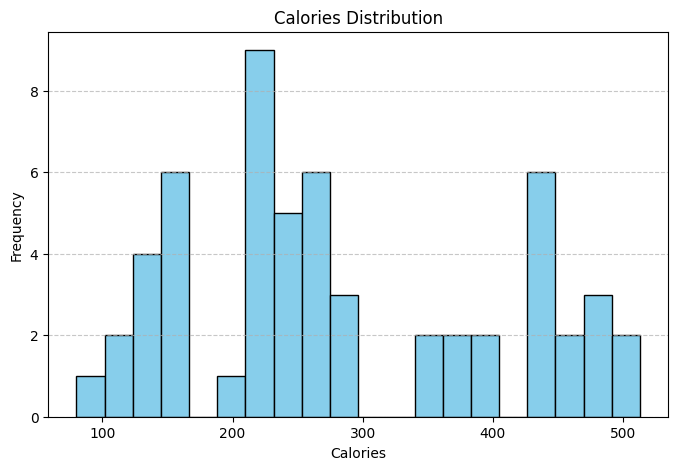

Unique Recipe Key combinations in the dataset: 30
   Recipe Key  Count
0          GF     47
8          DF     36
5          KF     33
7           Q     32
10         HP     27
3          AF     20
6          MP     16
11         LC     14
2           V     13
1          HF     11
4          FM     10
12          W     10
9          SC      3


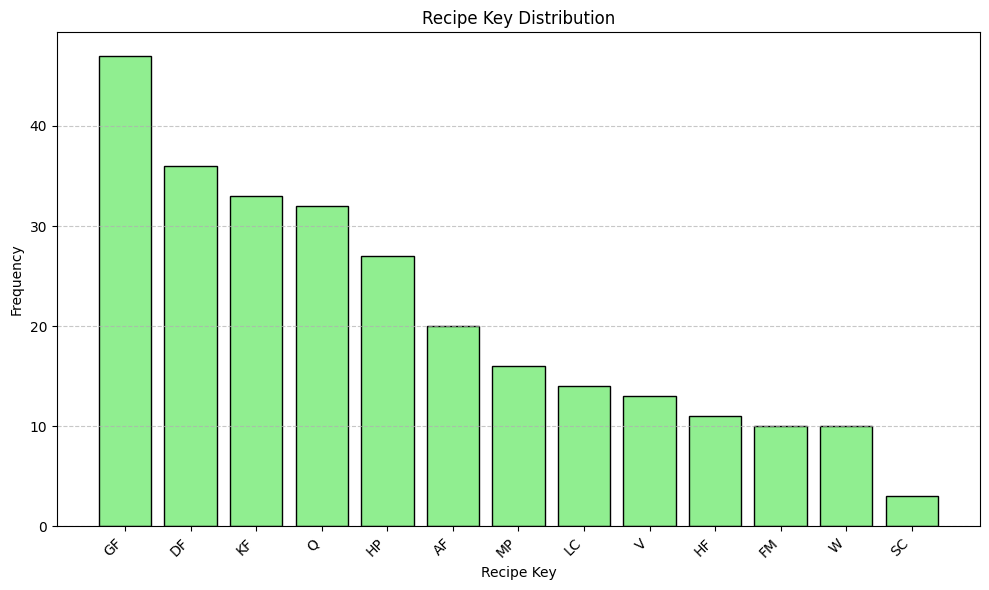

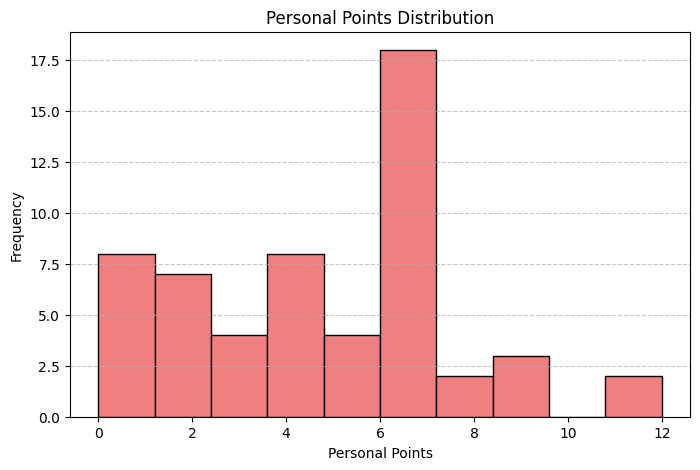

In [6]:

import matplotlib.pyplot as plt
from collections import Counter

# Load the filtered data from Step 2
filtered_data_file = 'filtered_skinnytaste_recipes.csv'
try:
    filtered_df = pd.read_csv(filtered_data_file)
    print("Filtered data loaded successfully.")
except Exception as e:
    print(f"Error loading filtered data: {e}")

# 1. Calories Distribution
# Filter out rows with missing Calories values for the distribution plot
calories_data = filtered_df["Calories"].dropna()

# Create a histogram for Calories distribution
plt.figure(figsize=(8, 5))
plt.hist(calories_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Calories Distribution')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Check the Recipe Key column for unique entries
unique_recipe_keys = filtered_df["Recipe Key"].unique()
print(f"Unique Recipe Key combinations in the dataset: {len(unique_recipe_keys)}")

# Check the split of recipe keys to verify the data
all_keys = [key for keys in filtered_df["Recipe Key"].dropna() for key in keys.split(", ")]

# Count the frequency of each recipe key
key_counts = Counter(all_keys)

# Convert the counts into a DataFrame for plotting
key_df = pd.DataFrame(key_counts.items(), columns=["Recipe Key", "Count"]).sort_values(by="Count", ascending=False)

# Display the aggregated key counts
print(key_df)

# Create a bar chart for Recipe Key distribution
plt.figure(figsize=(10, 6))
plt.bar(key_df["Recipe Key"], key_df["Count"], color='lightgreen', edgecolor='black')
plt.title('Recipe Key Distribution')
plt.xlabel('Recipe Key')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Points Distribution
# Filter out rows with missing Personal Points values for the distribution plot
points_data = filtered_df["Personal Points"].dropna()

# Create a histogram for Personal Points distribution
plt.figure(figsize=(8, 5))
plt.hist(points_data, bins=10, color='lightcoral', edgecolor='black')
plt.title('Personal Points Distribution')
plt.xlabel('Personal Points')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Step 4 – User interaction
Your code should be able to perform the following task:




*   Input a calorie range

*   Input a point range
*   Output the first 10 foods sorted based on calories, include their image and their summary.





In [7]:
!pip install pandas requests pillow

Data loaded successfully from filtered_skinnytaste_recipes.csv
Enter the minimum calories: 100
Enter the maximum calories: 250
Enter the minimum personal points: 2
Enter the maximum personal points: 5

Recipe 5
Name: Pumpkin Baked Oatmeal Cups
Calories: 104.0
Personal Points: 2
Summary: Made with pumpkin puree, oats, pumpkin pie spice, and Greek yogurt, these Pumpkin Baked Oatmeal Cups are an easy, creamy breakfast full of fall flavor. They're perfect to make in advance for breakfast on-the-go!
Image:


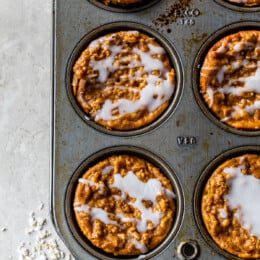


Recipe 3
Name: Crustless Pumpkin Pie
Calories: 124.5
Personal Points: 2
Summary: Skip the crust and make this easy dairy-free crustless pumpkin pie this fall for a cozy night when you crave a pumpkin treat or as a healthier alternative for Thanksgiving.
Image:


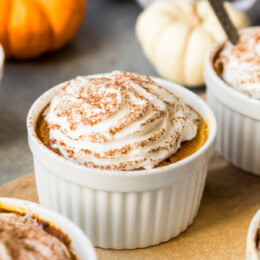


Recipe 20
Name: Grilled Pesto Chicken and Tomato Kebabs
Calories: 147.0
Personal Points: 2
Summary: Grilled Pesto Chicken and Tomato Kebabs are easy to make with boneless skinless chicken breast, tomatoes and basil pesto.
Image:


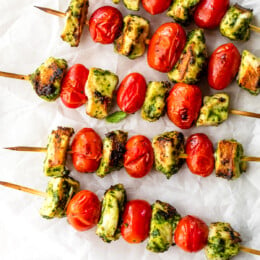


Recipe 27
Name: Air Fryer Baked Potato
Calories: 157.0
Personal Points: 4
Summary: Restaurant-style baked potatoes with crispy, salted skins and fluffy insides turn out perfectly in the air fryer at a fraction of the time it would take to make them in the oven.
Image:


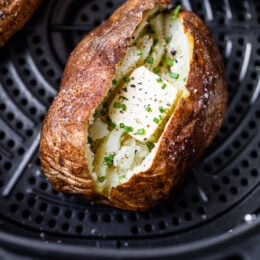


Recipe 1
Name: Roasted Butternut Squash Feta Soup
Calories: 200.0
Personal Points: 5
Summary: You’re going to love this creamy and delicious, Roasted Butternut Squash Feta Soup all made on a sheet pan then blended until smooth!
Image:


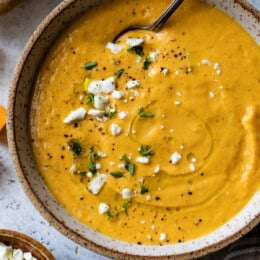


Recipe 51
Name: Baked Buffalo Chicken Nuggets
Calories: 211.0
Personal Points: 2
Summary: Healthy, Buffalo Chicken Nuggets baked in the oven are spicy and delicious! Crispy and golden on the outside with tender chicken breast on the inside, so good!
Image:


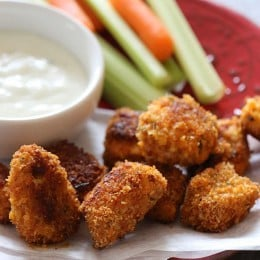


Recipe 13
Name: Savory Cottage Cheese Bowl
Calories: 221.0
Personal Points: 3
Summary: This Savory Cottage Cheese Bowl topped with veggies and pistachios is a protein-packed breakfast that will keep you full all morning.
Image:


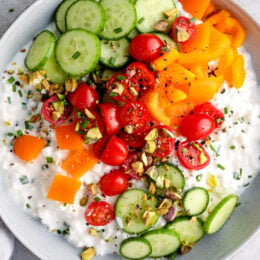


Recipe 28
Name: Air Fryer Steak
Calories: 221.0
Personal Points: 4
Summary: Make perfect Air Fryer Steak that is seared on the outside and juicy on the inside. Air frying steak is quick and easy with no splatter or mess in the kitchen!
Image:


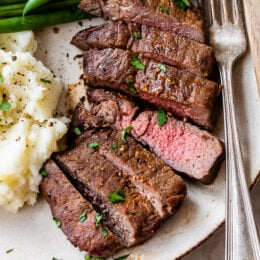


Recipe 21
Name: Grilled Chicken Shawarma
Calories: 240.0
Personal Points: 2
Summary: An easy, grilled chicken version of the classic Turkish street food which is usually cooked on a rotating spit. It is perfect served over couscous with yogurt and cucumbers as I did here, or try it with rice pilaf, or on a pita.
Image:


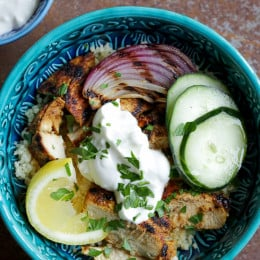

In [8]:


import requests
from PIL import Image
from io import BytesIO
from urllib.parse import urlparse

# Load the filtered dataset from Step 2
step2_data_file = "filtered_skinnytaste_recipes.csv"
try:
    data = pd.read_csv(step2_data_file)
    print(f"Data loaded successfully from {step2_data_file}")
except FileNotFoundError:
    print(f"Error: {step2_data_file} not found.")
    data = None

# Check if data is loaded successfully
if data is not None:
    # Function to take user input for calorie and point ranges
    def get_user_input():
        try:
            min_calories = int(input("Enter the minimum calories: "))
            max_calories = int(input("Enter the maximum calories: "))
            min_points = int(input("Enter the minimum personal points: "))
            max_points = int(input("Enter the maximum personal points: "))
        except ValueError:
            print("Invalid input. Please enter numerical values for the ranges.")
            return None

        return min_calories, max_calories, min_points, max_points

    # Get user input for the calorie and point ranges
    user_input = get_user_input()

    if user_input:
        min_calories, max_calories, min_points, max_points = user_input

        # Filter the data based on the provided ranges
        filtered_data = data[
            (data['Calories'] >= min_calories) &
            (data['Calories'] <= max_calories) &
            (data['Personal Points'] >= min_points) &
            (data['Personal Points'] <= max_points)
        ]

        # Remove duplicate recipes by name
        filtered_data = filtered_data.drop_duplicates(subset='Name')

        # Check if any data matches the filter criteria
        if not filtered_data.empty:
            # Sort the filtered data by calories in ascending order and take the top 10
            sorted_data = filtered_data.sort_values(by='Calories').head(10)

            # Display the first 10 foods along with their image and summary
            for index, row in sorted_data.iterrows():
                print(f"\nRecipe {index + 1}")
                print(f"Name: {row['Name']}")
                print(f"Calories: {row['Calories']}")
                print(f"Personal Points: {row['Personal Points']}")
                print(f"Summary: {row['Summary']}")

                # Download and display the image
                image_url = row['Image URL']

                # Check if the URL is valid and not a data URL
                if pd.notna(image_url) and image_url.strip() and not image_url.startswith("data:"):
                    try:
                        # Validate if the image_url is a proper URL
                        parsed_url = urlparse(image_url)
                        if all([parsed_url.scheme, parsed_url.netloc]):
                            response = requests.get(image_url)
                            image = Image.open(BytesIO(response.content))
                            print("Image:")
                            display(image)  # Display the image
                        else:
                            print("Invalid image URL.")
                    except Exception as e:
                        print(f"Failed to load image: {e}")
                else:
                    print("No valid image URL available for this recipe.")
        else:
            print("No recipes found within the given ranges.")
